# Smoothing
-----------

This notebook shows how to use `dysh` to smooth a spectrum.   For the example below we will use data from the Position-Switch example. The following dysh commands are the simplest to get and smooth a spectrum (leaving out all the function arguments):

      sdf = GBTFITSLoad()
      sb = sdf.getps()
      ta = sb.timeaverage()
      tb = ta.smooth()
      tb.plot()

or if you wish to make use of the Python object chaining:

       GBTFITSLoad().getps().timeaverage().smooth().plot()
      

In [1]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad

In [2]:
# show the mean and std for data and for a 1-rolled data
def rolled_stats(data, label='stats:'):
    delta = data[1:] - data[:-1]
    print(label,data.mean(), data.std(), delta.mean(), delta.std(), delta.std()/data.std()/np.sqrt(2))

# to test, check that rolled_stats has a sqrt(2) higher RMS
np.random.seed(123)
rolled_stats(np.random.normal(0,1,10000))

stats: 0.009711892291595955 0.9981138545901473 0.00020564491109648523 1.4025754219952096 0.9936447505035827


## Load the FITS file already used in the Position-Switch example

*future wish*:  this could be as simple as:

       filename = dysh_data(test='getps')


In [3]:
filename = "TGBT21A_501_11.raw.vegas.fits"
if not os.path.isfile(filename):
    url = f"http://www.gb.nrao.edu/dysh/example_data/onoff-L/data/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded")

TGBT21A_501_11.raw.vegas.fits already downloaded


In [4]:
sdfits = GBTFITSLoad(filename)

## Get a time-averaged spectrum at the highest resolution

This test data has only one integration of 1 second, so time averaging actually has no effect. Even though from the highest resolution one can clearly see a signal. Weighing by Tsys actually has no effect, since there is only one integration, but it is normally a good habit; plus it is actually the default.

*Technical note*: ``getps`` returns a **ScanBlock** with in this case a single PS **scan**, thus ``sb.timeaverage()`` is the same as ``sb[0].timeaverage()``, the latter only doing the first scan of the ScanBlock. The former would average all scans |(which can be dangerous)


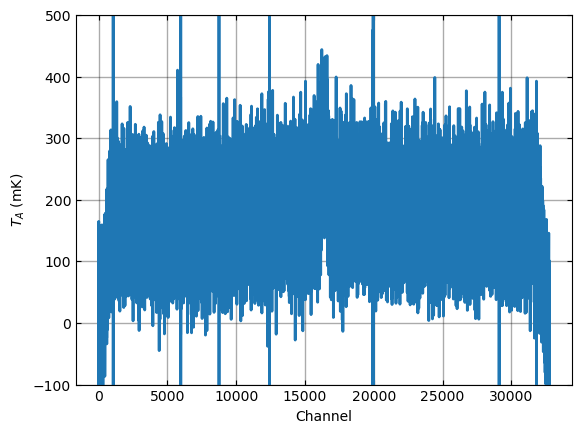

stats: 0.1802747611297031 K 0.05488477800860452 K 2.541479507945146e-05 K 0.07699206258407011 K 0.9919254759889891
expect:0.1802747611297031 K 0.05488477800860452 K (mean and std)


In [5]:
sb = sdfits.getps(scan=152, ifnum=0, plnum=0)
ta = sb.timeaverage(weights='tsys')
ta.plot(xaxis_unit="chan",yaxis_unit="mK",ymin=-100,ymax=500, grid=True)
rolled_stats(ta.flux[21000:28000])
print("expect:0.1802747611297031 K 0.05488477800860452 K (mean and std)")    # regression from previous runs

## Smooth in a few ways

By default smoothing will also decimate the signal, to (roughly) make each channel independant of the next. This assuming the input signal had independant channels. If the input was oversampled by a factor of 2, the smoothed signal will be as well, although you can manually decimate by a different value too, for example by using ``decimate=8`` .

Since we smooth to a gauss of FWHM 16 channels, the noise should go down by a factor of 4 (54 mK to 12 mK).


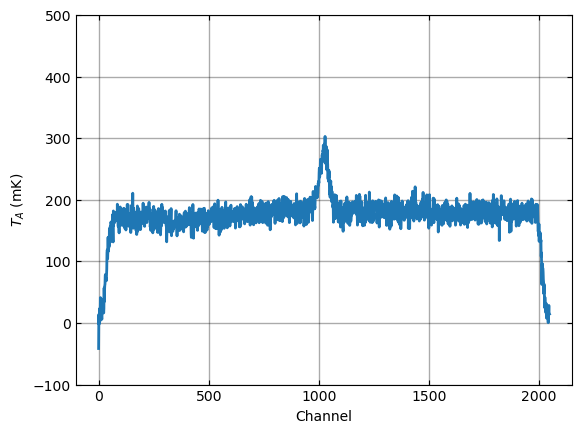

stats: 0.18024204126292784 K 0.011600120304973042 K 1.6157771324860886e-05 K 0.014307348963068595 K 0.8721309095605653


In [6]:
ts1 = ta.smooth('gaussian',16)
ts1.plot(xaxis_unit="chan",yaxis_unit="mK",ymin=-100,ymax=500,grid=True)
rolled_stats(ts1.flux[21000//16:28000//16])

Now smoothing by 320 channels should result in a noise of 55/sqrt(320) or 3 mK, exacty as measures. The rolled RMS ratio is very close to 1, so neighboring channels are not related. If you would decimate by 160, you would see this ratio drop. Be sure to adjust the range of channels for any new ``rolled_stats()``

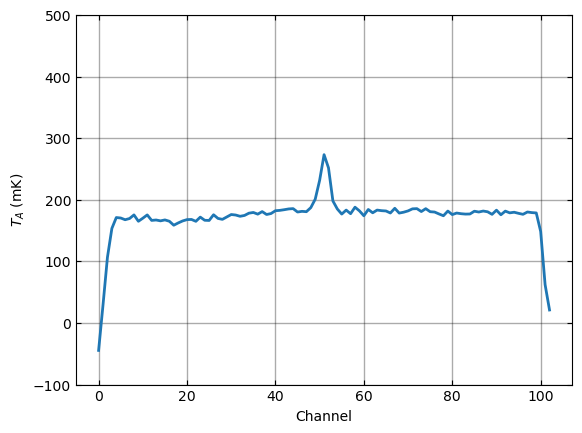

stats: 0.1801499633867924 K 0.003186119174117038 K 0.0001680022340288539 K 0.004449818195922424 K 0.9875640079458158


In [7]:
ts2 = ta.smooth('box', 320)
ts2.plot(xaxis_unit="chan",yaxis_unit="mK",ymin=-100,ymax=500, grid=True)
rolled_stats(ts2.flux[60:95])

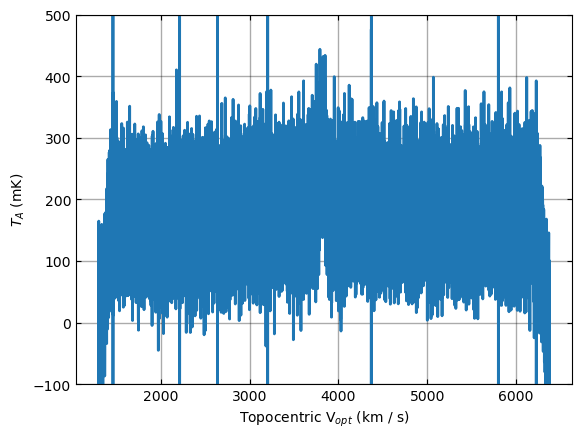

In [8]:
ta.plot(xaxis_unit="km/s",yaxis_unit="mK",ymin=-100,ymax=500)

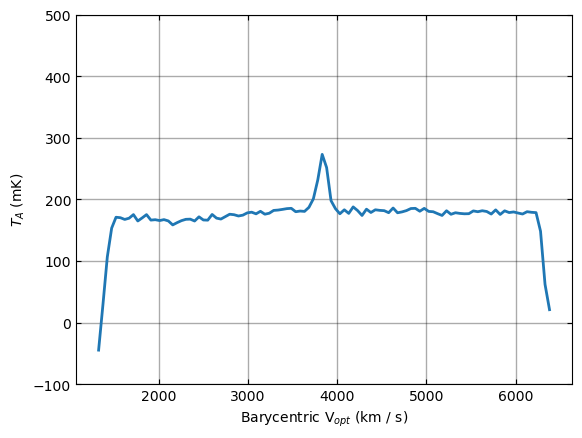

In [9]:
ts2.plot(xaxis_unit="km/s",yaxis_unit="mK",ymin=-100,ymax=500)

## Smoothing the reference ("OFF") scan

Under certain circumstances it can be beneficial to (boxcar) smooth the reference (OFF) signal before the usual
(ON-OFF)/OFF calibration. 

*Technical note*:  if you want to achieve identical results to GBTIDL, the width of the boxcar needs to be odd.


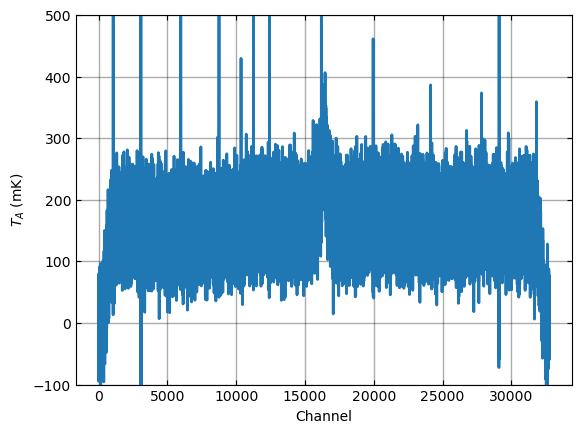

stats: 0.16747795774959787 K 0.039646959701565364 K 9.233633169265177e-06 K 0.054897591120875514 K 0.9791030445859087


In [10]:
sb = sdfits.getps(scan=152, ifnum=0, plnum=0, smoothref=31)
ta = sb.timeaverage(weights='tsys')
ta.plot(xaxis_unit="chan",yaxis_unit="mK",ymin=-100,ymax=500, grid=True)
rolled_stats(ta.flux[21000:28000])

We could smooth this spectrum the normal way, as was done a few cells ago, and not much difference is visible, except for the noise.


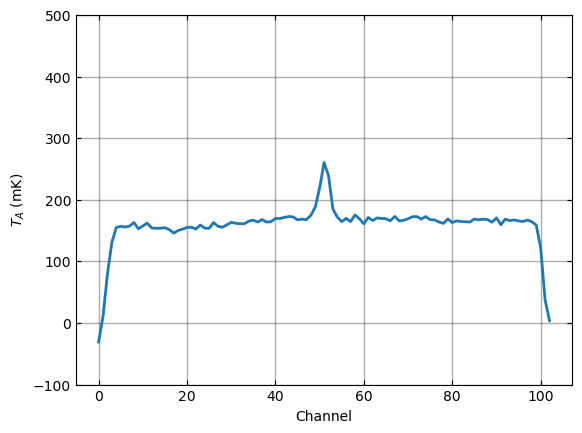

stats: 0.00471483628103625 K 0.04046117679516148 K -0.0005565789383104816 K 0.05214594520907628 K 0.911311889305439


In [11]:
ts2 = ta.smooth('box', 320)
ts2.plot(xaxis_unit="chan",yaxis_unit="mK",ymin=-100,ymax=500, grid=True)
rolled_stats(ta.flux[60:95])

Although the RMS has gone down (53mK to 40mK), the signal correlation has degraded a small amount from 0.98 to 0.91 due to the added correlation of the refernence smoothing.

## Successive smoothing check

Smoothing with a gaussian twice in a row should be the same as smoothing with a single gauss of the square root of the sum of their squares   Note that the **width** is the final width (FWHM) of the smoothing operation. We need to ignore decimation here, which is the third argument (-1), otherwise the spectra will have a different number of channels.

We plot the difference between the two smoothing routes, which is perhaps surprisingly still just below 1e-5. It is not closer to 0 due to the finite range the gaussian is sampled (to 4 sigma).

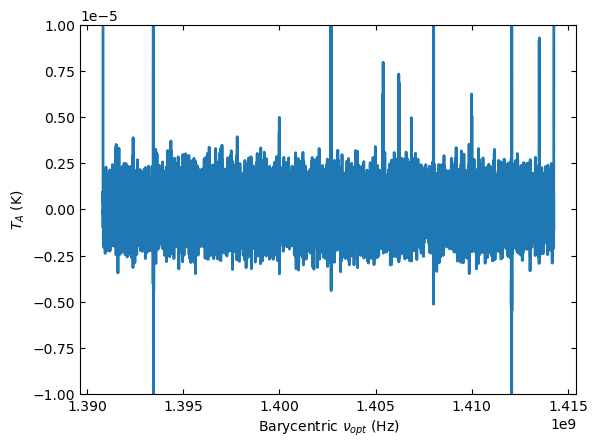

stats: -1.3494092238648076e-10 K 9.63247271150022e-07 K -1.4643085803290315e-10 K 1.2198442098965595e-06 K 0.8954711200782245


In [12]:
ts5a = ta.smooth('gaussian',3,-1).smooth('gaussian',5,-1)
ts5b = ta.smooth('gaussian',5,-1)
(ts5a-ts5b).plot(ymin=-0.00001, ymax=0.00001)
rolled_stats((ts5a-ts5b).flux[21000:28000])